[View in Colaboratory](https://colab.research.google.com/github/gauravbansal98/Autoencoders-on-MNIST-dataset/blob/master/Using_convolutional_layers.ipynb)

In [8]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

gpg: keybox '/tmp/tmpdqq1ddqx/pubring.gpg' created
gpg: /tmp/tmpdqq1ddqx/trustdb.gpg: trustdb created
gpg: key AD5F235DF639B041: public key "Launchpad PPA for Alessandro Strada" imported
gpg: Total number processed: 1
gpg:               imported: 1
··········


In [1]:
!mkdir -p drive
!google-drive-ocamlfuse drive

fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option


In [0]:
import os
import tensorflow as tf

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("drive/Autoencoders on MNIST dataset", one_hot = True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting drive/Autoencoders on MNIST dataset/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting drive/Autoencoders on MNIST dataset/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting drive/Autoencoders on MNIST dataset/t10k-images-idx3-ubyte.gz
Extracting drive/Autoencoders on MNIST dataset/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [0]:
import numpy as np
from skimage import transform
def resize_batch(imgs):
    # A function to resize a batch of MNIST images to (32, 32)
    # Args:
    #   imgs: a numpy array of size [batch_size, 28 X 28].
    # Returns:
    #   a numpy array of size [batch_size, 32, 32].
    imgs = imgs.reshape((-1, 28, 28, 1))
    resized_imgs = np.zeros((imgs.shape[0], 32, 32, 1))
    for i in range(imgs.shape[0]):
        resized_imgs[i, ..., 0] = transform.resize(imgs[i, ..., 0], (32, 32))
    return resized_imgs

In [0]:
import tensorflow.contrib.layers as lays
def autoencoder(inputs):
    # encoder
    # 32 x 32 x 1   ->  16 x 16 x 32
    # 16 x 16 x 32  ->  8 x 8 x 16
    # 8 x 8 x 16    ->  2 x 2 x 8
    net = lays.conv2d(inputs, 32, [5, 5], stride=2, padding='SAME')
    net = lays.conv2d(net, 16, [5, 5], stride=2, padding='SAME')
    net = lays.conv2d(net, 8, [5, 5], stride=4, padding='SAME')
    # decoder
    # 2 x 2 x 8    ->  8 x 8 x 16
    # 8 x 8 x 16   ->  16 x 16 x 32
    # 16 x 16 x 32  ->  32 x 32 x 1
    net = lays.conv2d_transpose(net, 16, [5, 5], stride=4, padding='SAME')
    net = lays.conv2d_transpose(net, 32, [5, 5], stride=2, padding='SAME')
    net = lays.conv2d_transpose(net, 1, [5, 5], stride=2, padding='SAME', activation_fn=tf.nn.tanh)
    return net

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Epoch: 1 - cost= 5.64128
Epoch: 2 - cost= 2.07409
Epoch: 3 - cost= 1.31838
Epoch: 4 - cost= 1.07204
Epoch: 5 - cost= 0.94913


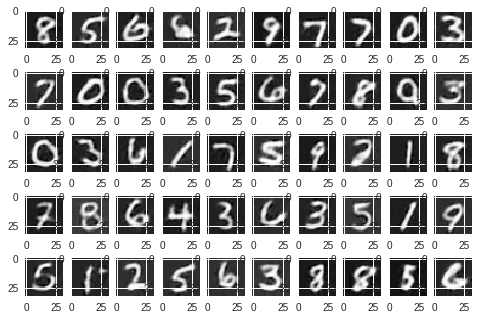

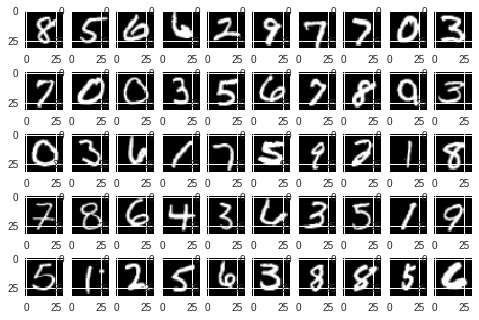

In [37]:
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
batch_size = 500  # Number of samples in each batch
epoch_num = 5     # Number of epochs to train the network
lr = 0.001        # Learning rate
ae_inputs = tf.placeholder(tf.float32, (None, 32, 32, 1))  # input to the network (MNIST images)
ae_outputs = autoencoder(ae_inputs)  # create the Autoencoder network
# calculate the loss and optimize the network
loss = tf.reduce_mean(tf.square(ae_outputs - ae_inputs))  # claculate the mean square error loss
train_op = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)
# initialize the network
init = tf.global_variables_initializer()
# calculate the number of batches per epoch
batch_per_ep = mnist.train.num_examples // batch_size
with tf.Session() as sess:
  sess.run(init)
  for ep in range(epoch_num):  # epochs loop
    batch_loss = 0
    for batch_n in range(batch_per_ep):  # batches loop
      batch_img, batch_label = mnist.train.next_batch(batch_size)  # read a batch
      batch_img = batch_img.reshape((-1, 28, 28, 1))               # reshape each sample to an (28, 28) image
      batch_img = resize_batch(batch_img)                          # reshape the images to (32, 32)
      _, c = sess.run([train_op, loss], feed_dict={ae_inputs: batch_img})
      batch_loss += c
    print('Epoch: {} - cost= {:.5f}'.format((ep + 1), batch_loss))
  # test the trained network
  batch_img, batch_label = mnist.test.next_batch(50)
  batch_img = resize_batch(batch_img)
  recon_img = sess.run([ae_outputs], feed_dict={ae_inputs: batch_img})[0]
  # plot the reconstructed images and their ground truths (inputs)
  plt.figure(1)
  plt.title('Reconstructed Images')
  for i in range(50):
      plt.subplot(5, 10, i+1)
      plt.imshow(recon_img[i, ..., 0], cmap='gray')
  plt.figure(2)
  plt.title('Input Images')
  for i in range(50):
      plt.subplot(5, 10, i+1)
      plt.imshow(batch_img[i, ..., 0], cmap='gray')
  plt.show()

**Another method where we use resizing instead of transpose convolution**

In [29]:
import tensorflow as tf

learning_rate = 0.001
inputs_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='inputs')
targets_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='targets')
### Encoder
conv1 = tf.layers.conv2d(inputs=inputs_, filters=32, kernel_size=(3,3), padding='same', activation=tf.nn.relu)
# Now 28x28x32
maxpool1 = tf.layers.max_pooling2d(conv1, pool_size=(2,2), strides=(2,2), padding='same')
# Now 14x14x32
conv2 = tf.layers.conv2d(inputs=maxpool1, filters=32, kernel_size=(3,3), padding='same', activation=tf.nn.relu)
# Now 14x14x32
maxpool2 = tf.layers.max_pooling2d(conv2, pool_size=(2,2), strides=(2,2), padding='same')
# Now 7x7x32
conv3 = tf.layers.conv2d(inputs=maxpool2, filters=16, kernel_size=(3,3), padding='same', activation=tf.nn.relu)
# Now 7x7x16
encoded = tf.layers.max_pooling2d(conv3, pool_size=(2,2), strides=(2,2), padding='same')
# Now 4x4x16
### Decoder
upsample1 = tf.image.resize_images(encoded, size=(7,7), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
# Now 7x7x16
conv4 = tf.layers.conv2d(inputs=upsample1, filters=16, kernel_size=(3,3), padding='same', activation=tf.nn.relu)
# Now 7x7x16
upsample2 = tf.image.resize_images(conv4, size=(14,14), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
# Now 14x14x16
conv5 = tf.layers.conv2d(inputs=upsample2, filters=32, kernel_size=(3,3), padding='same', activation=tf.nn.relu)
# Now 14x14x32
upsample3 = tf.image.resize_images(conv5, size=(28,28), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
# Now 28x28x32
conv6 = tf.layers.conv2d(inputs=upsample3, filters=32, kernel_size=(3,3), padding='same', activation=tf.nn.relu)
# Now 28x28x32
logits = tf.layers.conv2d(inputs=conv6, filters=1, kernel_size=(3,3), padding='same', activation=None)
#Now 28x28x1
# Pass logits through sigmoid to get reconstructed image
decoded = tf.nn.sigmoid(logits)
# Pass logits through sigmoid and calculate the cross-entropy loss
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits)
# Get cost and define the optimizer
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

sess = tf.Session()
epochs = 5
batch_size = 200
# Set's how much noise we're adding to the MNIST images
noise_factor = 0.5
sess.run(tf.global_variables_initializer())
for e in range(epochs):
  loss = 0
  for ii in range(mnist.train.num_examples//batch_size):
    batch = mnist.train.next_batch(batch_size)
    # Get images from the batch
    imgs = batch[0].reshape((-1, 28, 28, 1))

    # Add random noise to the input images
    noisy_imgs = imgs + noise_factor * np.random.randn(*imgs.shape)
    # Clip the images to be between 0 and 1
    noisy_imgs = np.clip(noisy_imgs, 0., 1.)
    
    # Noisy images as inputs, original images as targets
    batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: noisy_imgs,
                                                     targets_: imgs})
    loss += batch_cost
  print("Epoch: {}/{}...".format(e+1, epochs),"Training loss: {:.4f}".format(loss))

Epoch: 1/5... Training loss: 66.8478
Epoch: 2/5... Training loss: 44.9610
Epoch: 3/5... Training loss: 40.2867
Epoch: 4/5... Training loss: 37.9238
Epoch: 5/5... Training loss: 36.6091


(50, 28, 28, 1)
(50, 28, 28, 1)


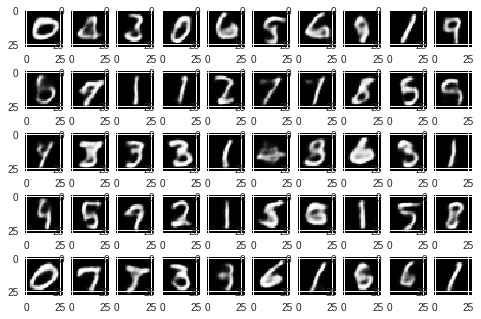

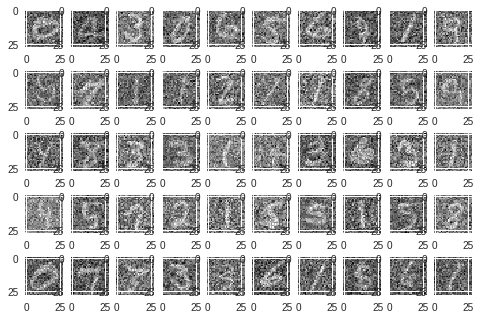

In [30]:
batch_img, batch_label = mnist.test.next_batch(50)
batch_img = batch_img.reshape((-1, 28, 28, 1))
batch_img =  batch_img + noise_factor * np.random.randn(*batch_img.shape)
noisy_imgs = np.clip(batch_img, 0., 1.)
print(np.shape(noisy_imgs))
recon_img = sess.run(decoded, feed_dict={inputs_: noisy_imgs})
print(recon_img.shape)
# plot the reconstructed images and their ground truths (inputs)
plt.figure(1)
plt.title('Reconstructed Images')
for i in range(50):
    plt.subplot(5, 10, i+1)
    plt.imshow(recon_img[i, ..., 0], cmap='gray')
plt.figure(2)
plt.title('Input Images')
for i in range(50):
    plt.subplot(5, 10, i+1)
    plt.imshow(batch_img[i, ..., 0], cmap='gray')
plt.show()